TODO's:
- Fix the inflow to ETCs!! - DONE
- Random travel to non-neighbouring regions - DONE
- Removal of ETCs possible - DONE
- Constraints for decision-making - DONE
- Information Delay! - (switched on by adding an extra 1 to the start of the lists in the function)- does this work for transmission??) (maybe get the number op patients from one timestep before) - DONE
- Implement Surveillance teams - DONE
- Implement exploration ratio as a function of system uncertainty
- Implement distinction between "blank" regions and regions with 0 uncertainty - DONE
- Uncertainty in neighbouring regions also reduced by an ETC!
- ETC: are they closed or "handed over" ? - DONE (handed over, can be switched "off") 


### Constants ###

In [23]:
fat_without = 0.4 #proportion of people dying without treatment
t_fat_without = 0.9 #time in weeks until death without treatment
t_rec_without = 2.5 #time in weeks until recovery without treatment

fat_with = 0.35 #proportion of people dying with treatment
t_fat_with = 1 #time in weeks until death with treatment
t_rec_with = 1.56 #time in weeks until recovery with treatment
safe_b_rate =0.73 #proportion of burials that are conducted safely



compartments = 6 #no. of compartments in the model
i_index = 1 #when listing the compartments, where the infected compartent is (starting from 0)

regions_list = [0,1,2,3] #list of the regions

#Exploration vs Exploitation ratio
explore = 0.5


### RESOURCES AVAILABLE ###
surveillance_capacity = 1
bed_capacity = 40 

### Objects ###

In [51]:
import random

class Uncertain_Constant:
    def __init__(self, ground_truth, variable_range):
        self.ground_truth = ground_truth
        self.variable_range = variable_range  #[value, value]
        self.original_range = variable_range
        self.percentage = 1.0
                
        
    def fuzzifier(self):
        
        if(self.percentage == 0):
            self.variable_range = [self.ground_truth, self.ground_truth]
        
        else:
            new_width = (self.original_range[1] - self.original_range[0]) * self.percentage
            
            in_current_range = False


            while in_current_range == False:
                z = new_width * random.uniform(0,1)
                new_range = [self.ground_truth - (new_width - z), self.ground_truth + z]


                if new_range[0] >= 0:
                    self.variable_range = new_range
                    in_current_range = True
                    
                
    def reduce_uncertainty(self, percentage):
        self.percentage = percentage
        self.fuzzifier()

        
        
class Uncertain_Variable:
    def __init__(self, ground_truth, variable_width):
        self.ground_truth = ground_truth
        self.variable_width = variable_width
        self.percentage = 1.0
        self.current_range = 0
        
        self.fuzzifier()
        
    def fuzzifier(self):
        
        if(self.percentage == 0):
            self.current_range = [self.ground_truth, self.ground_truth]
        
        else:
            new_range_width = self.variable_width * self.percentage * self.ground_truth
            valid_range = False
            while valid_range == False:
                z = new_range_width * random.uniform(0,1)
                new_range  = [self.ground_truth - (new_range_width - z), self.ground_truth + z]

                if new_range[0] >= 0:
                    self.current_range = new_range
                    valid_range = True
                    
                
    def reduce_uncertainty(self, percentage):
        self.percentage = percentage
        self.fuzzifier()
        
        
    def new_truth(self, ground_truth):
        self.ground_truth = ground_truth
        self.fuzzifier()
        

        
class Region:
    def __init__(self, number, susceptible, infected, recovered, deceased, funeral, treated, 
                 beta_i, beta_d, ETC_cap):
        self.number = number
        self.susceptible = [susceptible]
        self.infected = [infected]
        self.recovered = [recovered]
        self.deceased = [deceased]
        self.funeral = [funeral]
        self.treated = [treated]
        self.beta_i = beta_i
        self.beta_d = beta_d
        self.ETC_cap = ETC_cap
        #TO-DO: ranges are now hardcoded
        self.uncertain_I = Uncertain_Variable(infected, 2.5)
        self.uncertain_bi = Uncertain_Constant(beta_i, [0.06,0.4])
        
        self.ETCs = []
        self.cummulative_patients = 0
        #to model the time delay in uncertainty reduction, we need to also keep track of the cummulative number of patients one timestep back
        self.cummulative_patients_prev = 0
        
        self.hidden = True
        self.ST = None
        
    
    def update(self,compartments_list):
        
        self.susceptible.append(compartments_list[0])
        self.infected.append(compartments_list[1])
        self.recovered.append(compartments_list[2])
        self.deceased.append(compartments_list[3])
        self.funeral.append(compartments_list[4])
        self.treated.append(compartments_list[5])
        
        self.uncertain_I.new_truth(self.infected[-1])
        
        
        
    def placement_decision(self, timestep, capacity):
        if self.hidden == True:
            self.hidden = False
        self.ETCs.append(ETC(capacity,timestep))
        
    def surveillance_team(self, timestep):
        self.hidden = False
        self.ST = Surveillance_Team(timestep)
        
    def calculate_capacity(self, timestep, regions):
        for ETC in self.ETCs:
            if ETC.timestep_opened == timestep:
                self.ETC_cap += ETC.capacity
            
            #once an ETC is opened, uncertainty is also reduced in neighbouring regions. One week of information delay.
            if ETC.timestep_opened + 1 == timestep:
                #get all the neighbours
                neighbours = get_neighbours(self.number-1,regions_list)
                for neighbour in neighbours:
                    updateable_region = regions[int(neighbour)]
                    
                    if updateable_region.hidden == True:
                        updateable_region.hidden = False
                    
                    if updateable_region.uncertain_I.percentage > 0.95:
                        updateable_region.uncertain_I.percentage = 0.95 
                
                    if updateable_region.uncertain_bi.percentage > 0.95:
                        updateable_region.uncertain_bi.percentage = 0.95
                    
                
            
            '''
            #Remove this if you maintain (local) capacity even if resources are removed
            if ETC.timestep_closed == timestep:
                self.ETC_cap -= ETC.capacity
            '''
    
    def update_cummulative_patients(self):
        
        self.cummulative_patients_prev = self.cummulative_patients
        
        self.cummulative_patients += self.treated[-1] - (self.treated[-2] - (self.treated[-2]*fat_with/t_fat_with 
                                                                             + self.treated[-2]*(1-fat_with)/t_rec_with))
           
    def spontaneous_news(self):
        no_infected = self.infected[-1]
        
        p = 1-1/(1+math.e**((no_infected-40)/7))
        
        i  = random.uniform(0,1)
        
        if i <= p:
            self.hidden = False
            print("Spontaneous news from region ", self.number)
        
        

class ETC:
    def __init__(self, capacity, timestep_placed):
        self.capacity = capacity
        self.timestep_placed = timestep_placed
        
        if(capacity == 10):
            self.timestep_opened = timestep_placed + 1
        if(capacity == 50):
            self.timestep_opened = timestep_placed + 3
        
        self.timestep_closed = -1
    
    def close_ETC(self, timestep):
        if self.capacity == 10:
            self.timestep_closed = timestep + 1
        elif self.capacity == 50:
            self.timestep_closed = timestep + 2
            

class Surveillance_Team:
    def __init__(self,timestep_placed):
        self.timestep_placed = timestep_placed
        self.timestep_closed = -1
        
    def close_ST(self,timestep):
        self.timestep_closed = timestep
        

        
### Function to calculate the total amount of resources currently deployed ###

def resources_in_use(regions, timestep):
    beds_in_use = 0
    for region in regions:
        for ETC in region.ETCs:
            if ETC.timestep_closed == -1 or not timestep >= ETC.timestep_closed:
                #even if the ETC is not open yet, it is assumed those resources are occupied.
                #the only time the resources are no longer occupied is when the ETC is shut down.
                beds_in_use += ETC.capacity
                
    return beds_in_use

def surveillance_teams_in_use(regions,timestep):
    st_in_use = 0
    for region in regions:
        if region.ST:
            if region.ST.timestep_closed == -1:
                st_in_use += 1
                
    return st_in_use
  

### Helper functions ###

In [52]:
### Functions for the Uncertainty Reduction ###
import math

def unc_infected(region, timestep):
    
    ETC_50 = [1.0,0.95,0.85,0.7,0.5,0.325,0.25,0.225,0.21,0.2]
    ETC_10 = [1.0,0.95,0.7,0.55,0.45,0.375,0.325,0.30]

    perc_reduced = 1.0
    ETCs = region.ETCs
    for ETC in ETCs:
        if ETC.capacity == 50:
            weeks = timestep - ETC.timestep_placed
            
            if weeks >= len(ETC_50):
                percentage = ETC_50[-1]
            else:
                percentage = ETC_50[weeks]
                
            if perc_reduced > percentage:
                perc_reduced = percentage
                
        elif ETC.capacity == 10:
            weeks = timestep - ETC.timestep_placed
            
            if weeks >= len(ETC_10):
                percentage = ETC_10[-1]
            else:
                percentage = ETC_10[weeks]
                
            if perc_reduced > percentage:
                perc_reduced = percentage

    return perc_reduced
        
####CHECK THIS ONE
def unc_transmission(cumm_patients):
    if cumm_patients > 100:
        return 0
    else:
        return math.e**(-cumm_patients/15)

In [53]:
### Function to Determine the Neighbouring Regions ###

import math

def get_neighbours(i,square_list):
    l = len(square_list)
    row = math.sqrt(l)

    if(i < row):
            #this is the top row

        if(i == 0):
            #it's the first entry of the row
            neighbours = [i+1,i+row]
        elif(i == row-1):
            #it's the last entry of the row
            neighbours = [i-1,i+row]
        else:
            neighbours = [i-1, i+1, i+row]
            
    elif(i > l-1-row):
            #this is the bottom row

        if(i == l-row):
            #it's the first entry of the row
            neighbours = [i+1, i-row]
        elif (i == l-1):
            #it's the last entry of the row
            neighbours = [i-1, i-row]
        else:
            neighbours = [i-1, i+1, i-row]

    else:
            #it's a middle row 

        if (i % row == 0):    
            #it's the first entry of a row
            neighbours = [i+1, i-row, i+row]
        elif (i % row == (row-1)):
            #it's the last entry of a row
            neighbours = [i-1, i-row, i+row]
        else:
            #it's a "middle" entry
            neighbours = [i-1,i+1,i-row,i+row]
    
    return neighbours
        

def random_travelling(regions, population):
    
    total_infected = 0

    for i in range(0,len(regions)):
        total_infected += population[i*compartments+i_index]
        
    if total_infected < 1:
        pass
    
    #the "probability" of having one or more random travellers is dependent on the number of infected people
    p = total_infected*0.005
    
    print(total_infected,p)
    
    #if p > 1 then we have at least 1 traveller
    travellers = int(p)
    
    #if there are more than the int travelers is determined with some probability
    if p > 1:
        if p - travellers > random.uniform(0,1):
            travellers += 1
    else:
        if p > random.uniform(0,1):
            travellers += 1
    
    #now every traveller needs to travel
    for i in range(travellers):
    
        #for every traveller we need to have a region of departure. There need to be infected people in this region
        infected_region = False
        while infected_region == False:
            random_departure_region = random.choice(regions)
            if population[(random_departure_region.number-1)*compartments+i_index] >= 1:
                infected_region = True
                
        neighbouring_regions = get_neighbours(random_departure_region.number-1,regions_list)
        
        #the destination region needs to be a non-neighbouring region (And also not the region of departure)
        suitable_destination = False
        while suitable_destination == False:
            random_destination = random.choice(regions)
            if random_destination.number != random_departure_region.number and not random_destination.number - 1 in neighbouring_regions:
                suitable_destination = True
                    
        print("A person is moving from region ", random_departure_region.number)
        print("to region ", random_destination.number)
        #remove the person from the region of origin and add them to the destination
        population[(random_departure_region.number-1)*compartments+i_index] -= 1
        population[(random_destination.number-1)*compartments+i_index] += 1
        
    
    return population

In [54]:
### Decision-making functions ###


def explorative_decision(regions,x):
        
        available_st = surveillance_capacity - surveillance_teams_in_use(regions,x)
        
        #Surveillance teams only have an effect on hidden regions. Check if there are still hidden regions
        still_hidden = False
        for region in regions:
            if region.hidden == True:
                still_hidden = True
        
        #if there is capacity and there are still hidden regions, we can employ surveillance teams
        if available_st and still_hidden:
            
            hidden_regions = []
            
            for region in regions:
                if region.hidden == True:
                    hidden_regions.append(region)
                    
            for i in range(available_st):
                chosen_region = random.choice(hidden_regions)
                chosen_region.surveillance_team(x)
                print("A surveillance team has been deloyed to region", chosen_region.number)

        
        #Else we can (further) reduce uncertainty using a small ETC
        else:
            options = []
            highest_uncertainty = 0

            #iterate over the regions, store the one with the highest uncertainty            
            for region in regions:

                uncertainty = region.uncertain_I.percentage + region.uncertain_bi.percentage
                if region.hidden == True:
                    #If a region is hidden, the uncertainty is 1.5 + 1.5 = 3
                    uncertainty = 3

                if uncertainty > highest_uncertainty:
                    highest_uncertainty = uncertainty
                    options = [region]
                elif uncertainty == highest_uncertainty:
                    options.append(region)

            #if there are multiple region with the same level of uncertainty, choose one at random            
            if len(options) != 1:
                    chosen_region = random.choice(options)
            else:
                    chosen_region = options[0]

            print(resources_in_use(regions,x))

            #For now, we always place a small ETC because this gives the fastest reduction.
            if bed_capacity - resources_in_use(regions,x) >= 10:
                chosen_region.placement_decision(x,10)
                print("I'm making an explorative decision to place a small ETC in region ", chosen_region.number)
            else:
                print("I wanted to make an explorative decision but there was no capacity")
        
def exploitative_decision(regions,x):
        #beta_i*infected * (susceptible /(susceptible + infected) (for now we don't take into account the deceased/funerals)
            
        highest_infected = 0
        options = []
            
        for region in regions:
            
            if region.hidden == False:

                #conservative choice: choose the region with the highest no of infections according to the lower bound
                #for the next timestep
                infected = region.uncertain_I.current_range[0] + region.uncertain_I.current_range[0] * region.uncertain_bi.variable_range[0] * (10000 / (10000 + region.uncertain_I.current_range[0]))

                if infected > highest_infected:
                    highest_infected = infected
                    options = [region]
                elif infected == highest_infected:
                    options.append(region)
        
        

        if not options:
            #all the regions are hidden. We do nothing
            print("I wanted to take an exploitative action but all the regions are hidden")
            
        else:
            #if there are multiple regions with the same number of infected people, choose one at random
            if len(options) != 1:
                chosen_region = random.choice(options)
            else:
                chosen_region = options[0]

            print(resources_in_use(regions,x))    

            if highest_infected >= 50:
                if bed_capacity - resources_in_use(regions,x) >= 50:
                    chosen_region.placement_decision(x,50)
                    print("I'm making an exploitaive decision to place a big ETC in region", chosen_region.number)
                elif bed_capacity - recources_in_use(regions,x) >= 10:
                    chosen_region.placement_decision(x,10)
                    print("I wanted to place a big ETC but there was not enough capacity so I placed a small one in region", chosen_region.number)
                else:
                    print("I wanted to place a big ETC but there was no capacity to do anything in region", chosen_region.number)

            else:
                if bed_capacity - resources_in_use(regions,x) >= 10:
                    chosen_region.placement_decision(x,10)
                    print("I'm making an exploitative decision to place a small ETC in region", chosen_region.number)
                else:
                    print("I wanted to place a small ETC but there was no capacity to do anything in region", chosen_region.number)

                
def check_for_removal(regions,timestep):
    for region in regions:
        #if there are fewer than 5 infected people in the region we assume "The worst is over"
        #and start handing over to locals
        
        #TO-DO: Now we're suddenly accessing a ground truth, DM can't do that!!!
        if region.infected[-1] < 5:
            for ETC in region.ETCs:
                #check if it's not already closed
                if ETC.timestep_closed == -1:
                    #check if it has been open for 2 weeks
                    #assumption: takes at least 2 weeks before local staff has been sufficiently trained
                    if timestep >= ETC.timestep_opened + 2:
                        print("I am removing (a) ETC(s) in region", region.number)
                        ETC.close_ETC(timestep)

                        
def check_surveillance_removal(regions,timestep):
    for region in regions:
        if region.ST:
            if region.ST.timestep_placed + 1 == timestep:
                region.ST.close_ST(timestep)

In [55]:
### Helper functions for the Compartmental Model ###

#change in susceptible people
def f_dsdt(susceptible, infected, deceased, beta_i, beta_d):
    return -(beta_i*infected + beta_d*deceased) * (susceptible /(susceptible + infected))

#change in recovered people
def f_drdt(infected, treated):
    return ((1-fat_without)*infected) / t_rec_without + (1-fat_with)*treated / t_rec_with

#change in infected people
#with travelling
def f_didt(susceptible, infected, deceased, treated, neighbours, no_neighbours, beta_i, beta_d, travel_rate, ETC_cap):
    if treated < ETC_cap:
        return ((beta_i*infected + beta_d*deceased) * (susceptible /(susceptible + infected))
                + travel_rate * neighbours
                - travel_rate * infected
            - ((1 - fat_without)*infected) / t_rec_without
           - fat_without*infected / t_fat_without
            - min(ETC_cap - treated, infected)/0.001) 
    else:
        return ((beta_i*infected + beta_d*deceased) * (susceptible /(susceptible + infected))
                + travel_rate * neighbours
                - travel_rate * infected
               - ((1-fat_without)*infected) / t_rec_without
               - fat_without*infected / t_fat_without)

#change in treated people
def f_dtrdt(infected, treated, ETC_cap):
    if treated < ETC_cap:
        return min(ETC_cap - treated, infected)/0.001 -(1-fat_with)*treated / t_rec_with - fat_with*treated / t_fat_with
    else:
        return -(1-fat_with)*treated / t_rec_with - fat_with*treated / t_fat_with

    
#change in deceased people
def f_dddt(infected, deceased):
    return (fat_without*infected) / t_fat_without - deceased * safe_b_rate

def f_dfdt(deceased, treated):
    return deceased * safe_b_rate + fat_with*treated / t_fat_with

### Compartmental Model ###

In [56]:
def calc_population(y,t, regions, travel_rate):
    
    dydt = []
    
    #regions = [region1, region2, region3, region4]
    
    #we have a long list of regions, loop over them 
    for i in range(0,len(regions)):
    
        #here we grab the compartments for every region
        susceptible, infected, recovered, deceased, funeral, treated = y[i*compartments:i*compartments+compartments]
        
        #and get the (number of) neighbours
        neighbouring_regions = get_neighbours(i,regions_list)
        no_neighbours = len(neighbouring_regions)
        
        neighbours = 0;
        
        #how many infected individuals there are in the neighbouring regions
        for j in range(0,len(neighbouring_regions)):
            region = neighbouring_regions[j]
            
            no_region_neighbours = len(get_neighbours(region,regions_list))
            
            #not all travelling people will go to the one region, so divide by the number of neighbours
            neighbours += y[int(region*compartments+i_index)]/no_region_neighbours
            
        #grab the parameters from the region objects
        beta_i = regions[i].beta_i
        beta_d = regions[i].beta_d
        
        ETC_cap = regions[i].ETC_cap
        


        #update all the compartments of the region accordingly
        dsdt = f_dsdt(susceptible, infected, deceased, beta_i, beta_d)

        didt = f_didt(susceptible, infected, deceased, treated, neighbours, no_neighbours, beta_i, beta_d, travel_rate, ETC_cap)



        drdt = f_drdt(infected, treated)

        dddt = f_dddt(infected, deceased)
        dfdt = f_dfdt(deceased, treated)
            
        dtrdt = f_dtrdt(infected, treated, ETC_cap)
        #print(dtrdt)
        
        #and append the outcomes to the list that the function will return
        dydt.extend([dsdt,didt,drdt,dddt,dfdt,dtrdt])
        

    

    return dydt

### General Ebola Model ###

In [60]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

def ebola_model(I1 = 0,
                I2 = 0,
                I3 = 0,
                I4 = 0,
                beta_i1 = 0.33,
                beta_i2 = 0.33,
                beta_i3 = 0.33,
                beta_i4 = 0.33,
                beta_d = 0.68,
                travel_rate = 0.05):
    
    time_vec = np.linspace(0,1,2)
    


    region1 = Region(1, (10000-1.5*I1), I1, 0, (0.5*I1), 0, 0, beta_i1, beta_d, 0)
    region2 = Region(2, 10000-1.5*I2, I2, 0, 0.5*I2, 0, 0, 
                 beta_i2, beta_d, 0)
    region3 = Region(3, 10000-1.5*I3, I3, 0, 0.5*I3, 0, 0, 
                 beta_i3, beta_d, 0)
    region4 = Region(4, 10000-1.5*I4, I4, 0, 0.5*I4, 0, 0, 
                 beta_i4, beta_d, 0)
    
    regions = [region1, region2, region3, region4]
    
    y0 = []
    
    for region in regions:
        y0.extend([region.susceptible[0], region.infected[0], region.recovered[0], region.deceased[0], region.funeral[0], region.treated[0]])

    
    for x in range (0,10):
        
        print("Timestep ", x)
        
        for region in regions:
            
            #in some "hidden" regions, the # of patients may be so high we hear about it spontaneously
            if region.hidden == True:
                region.spontaneous_news()
            
            #update uncertainties
            if region.uncertain_I.percentage != unc_infected(region,x):
                region.uncertain_I.reduce_uncertainty(unc_infected(region, x))
                
            if region.uncertain_bi.percentage != unc_transmission(region.cummulative_patients_prev):
                region.uncertain_bi.reduce_uncertainty(unc_transmission(region.cummulative_patients_prev))
            
            
        
        #make decisions
        decision_type  = random.uniform(0,1)
        if decision_type < explore:
            
            #take an explorative action
            explorative_decision(regions,x)

        else:
            #take an exploitative action
            exploitative_decision(regions,x)

        
        #See if any resources can be freed for the next timestep:
        
        #check if any ETCs can be closed down
        check_for_removal(regions,x)
        
        #check if any surveillance teams are "done"
        check_surveillance_removal(regions,x)
        
        #update the ETC capacity of each region
        for region in regions:
            region.calculate_capacity(x, regions)
            
        
        #Run the compartmental model for 1 timestep                                                                                  
        population, infodict = odeint(calc_population, y0, t=time_vec, args=(regions, travel_rate), full_output = 1)
        
        #random travelling takes place here. The function returns the new list of the population, regardless of whether random travel occured
        random_travelling(regions, population.T[:,1])
        
        #grab the states of the compartments at the end of the timestep
        y0 = population.T[:,1]
       

        
        #store the results and update the region objects
        for i in range(0,len(regions)):
            regions[i].update(y0[i*compartments:i*compartments+compartments])
            regions[i].update_cummulative_patients()


        
    results = []
    for region in regions:
        results.append(region.susceptible)
        results.append(region.infected)
        results.append(region.recovered)
        results.append(region.deceased)
        results.append(region.funeral)
        results.append(region.treated)

        
    return results

### EMA Workbench ###

In [61]:
from ema_workbench import Model, IntegerParameter, RealParameter, TimeSeriesOutcome

model = Model('Ebola', function=ebola_model)

model.uncertainties = [IntegerParameter('I1', 0, 50),
                       IntegerParameter('I2', 0, 50),
                       IntegerParameter('I3', 0, 50),
                       IntegerParameter('I4', 0, 50),
                       RealParameter('beta_i1', 0.06, 0.4),
                       RealParameter('beta_i2', 0.06, 0.4),
                       RealParameter('beta_i3', 0.06, 0.4),
                       RealParameter('beta_i4', 0.06, 0.4)]

model.outcomes = [TimeSeriesOutcome('S1'),
                  TimeSeriesOutcome('I1'),
                  TimeSeriesOutcome('R1'),
                  TimeSeriesOutcome('D1'),
                  TimeSeriesOutcome('F1'),
                  TimeSeriesOutcome('T1'),
                  TimeSeriesOutcome('S2'),
                  TimeSeriesOutcome('I2'),
                  TimeSeriesOutcome('R2'),
                  TimeSeriesOutcome('D2'),
                  TimeSeriesOutcome('F2'),
                  TimeSeriesOutcome('T2'),
                  TimeSeriesOutcome('S3'),
                  TimeSeriesOutcome('I3'),
                  TimeSeriesOutcome('R3'),
                  TimeSeriesOutcome('D3'),
                  TimeSeriesOutcome('F3'),
                  TimeSeriesOutcome('T3'),
                  TimeSeriesOutcome('S4'),
                  TimeSeriesOutcome('I4'),
                  TimeSeriesOutcome('R4'),
                  TimeSeriesOutcome('D4'),
                  TimeSeriesOutcome('F4'),
                  TimeSeriesOutcome('T4')]

Timestep  0
Spontaneous news from region  1
A surveillance team has been deloyed to region 2
63.58992670683979 0.31794963353419897
Timestep  1
0
I'm making an exploitative decision to place a small ETC in region 1
58.402803816803534 0.2920140190840177
Timestep  2
10
I'm making an exploitative decision to place a small ETC in region 1
41.85808056817804 0.2092904028408902
Timestep  3
A surveillance team has been deloyed to region 4
22.75588265533609 0.11377941327668045
A person is moving from region  2
to region  3
Timestep  4
20
I'm making an explorative decision to place a small ETC in region  4
I am removing (a) ETC(s) in region 1
21.784514124880012 0.10892257062440006
Timestep  5
20
I'm making an explorative decision to place a small ETC in region  2
I am removing (a) ETC(s) in region 1
10.855884154603661 0.054279420773018304
Timestep  6
20
I'm making an explorative decision to place a small ETC in region  3
3.1400303349383587 0.015700151674691794
Timestep  7
30
I'm making an exploit

C:\Users\Emma\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


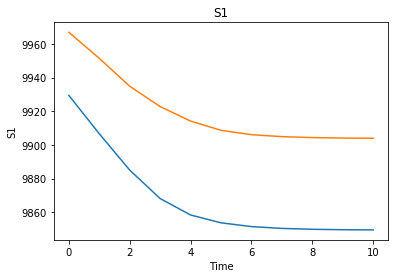

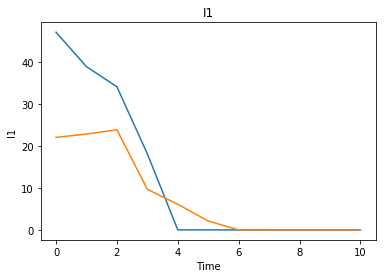

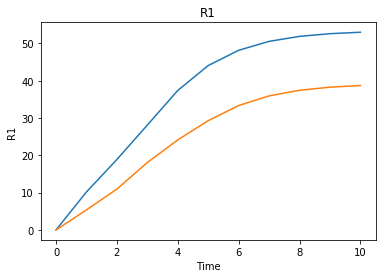

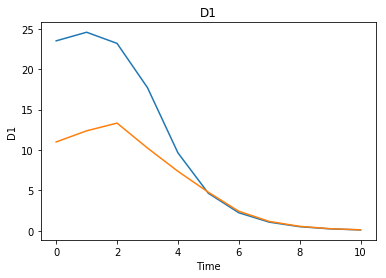

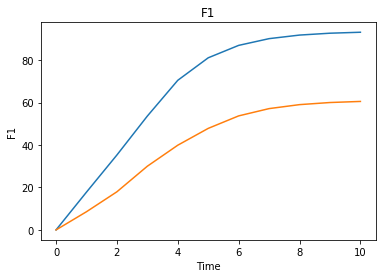

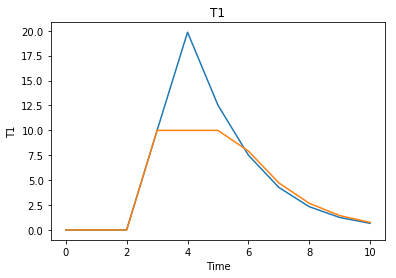

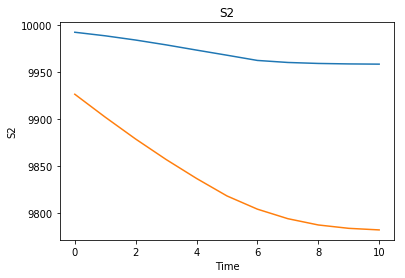

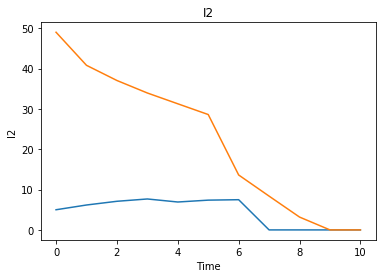

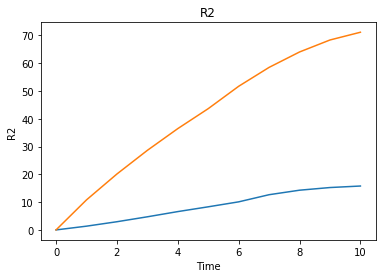

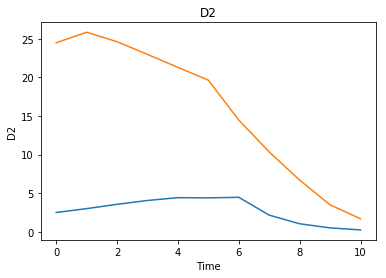

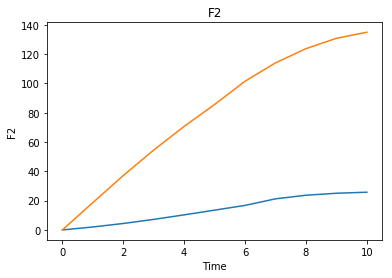

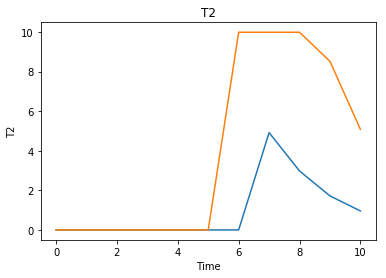

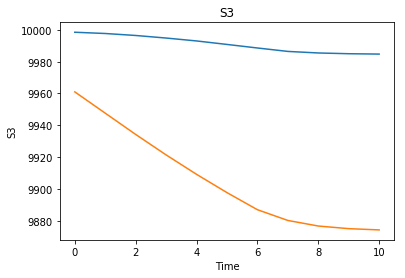

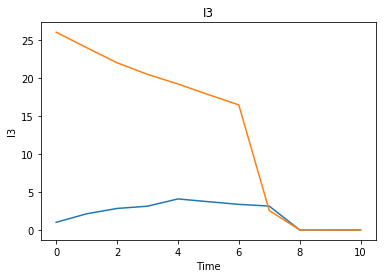

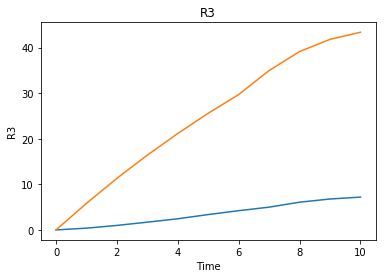

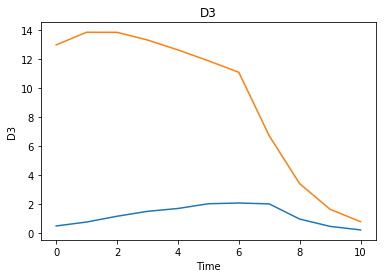

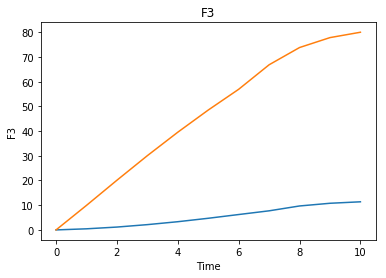

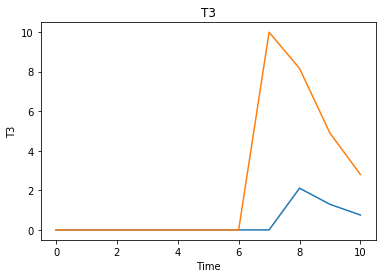

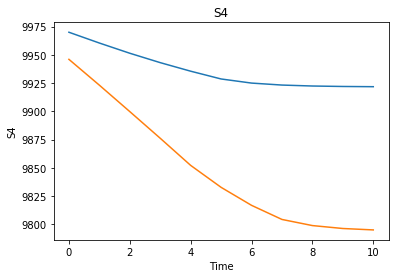

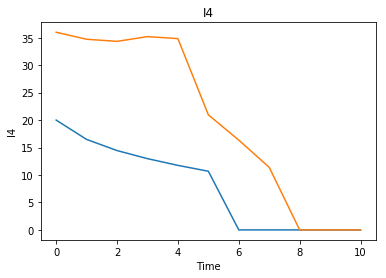

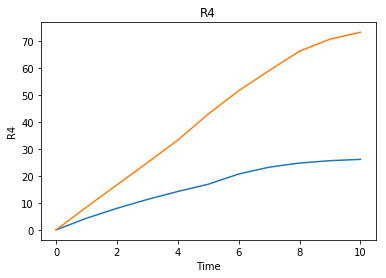

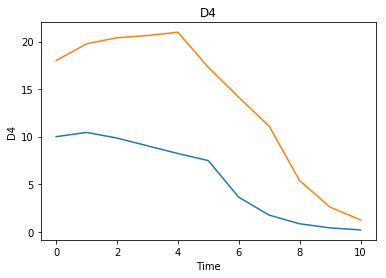

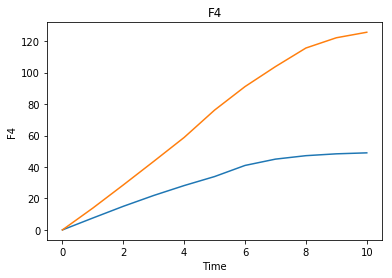

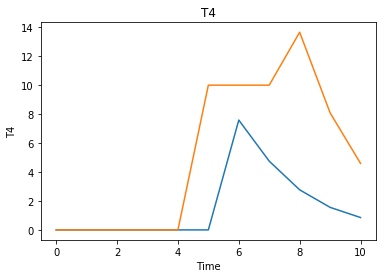

In [59]:
from ema_workbench import SequentialEvaluator

with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=2)
    
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes.keys():
    plotting.lines((experiments, outcomes), outcomes_to_show=outcome, 
                   density=False)
plt.show()